This notebook analyses our results for the success probability and median running time of QAOA for $k$-SAT.

In [163]:
import os
import sys
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
parent_dir = os.path.dirname(os.getcwd())

In [164]:
# Parameters
ps = [1, 2, 4, 8, 16]
ks = [4, 8]
ns = [i for i in range(12, 21)]
num_proc = 10
batch_size = 250

First we analyse the success probability

In [165]:
# Extract psucc p=1,2,4,8,16
dir = f'{parent_dir}/experiments/ksat_eval/ksat_p_succ'
psuccs = {k : {n : {p : 0 for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/k_{k}/p_succ_{n}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				psuccs[k][n][p] += data[str(n)][str(p)] / (batch_size * num_proc)

In [166]:
# Extract error
errs = {k : {n : {p : 0 for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			index = proc * batch_size
			filename = f'{dir}/k_{k}/p_succ_{n}_{index}.json' 
			with open(filename, 'r') as f:
				data = json.load(f)
			for p in ps:
				errs[k][n][p] += ((data[str(n)][str(p)]/batch_size - psuccs[k][n][p]) ** 2) / (batch_size * num_proc)

<Figure size 1500x1000 with 0 Axes>

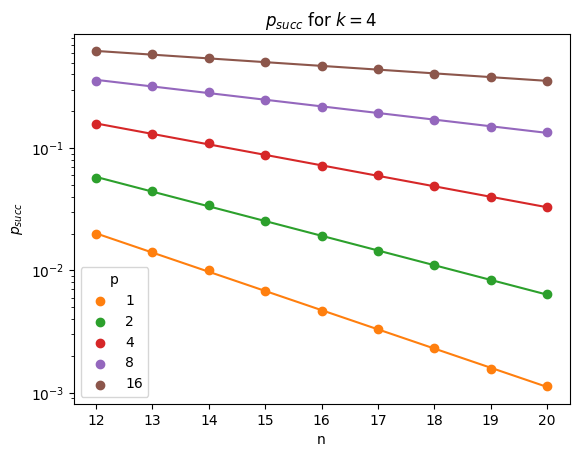

<Figure size 1500x1000 with 0 Axes>

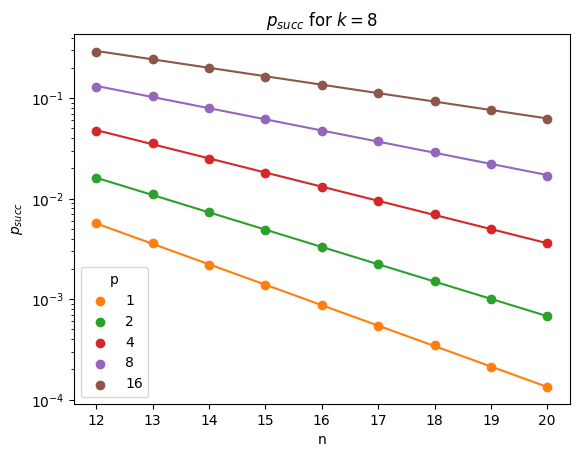

In [167]:
# Plot psucc p=1,2,4,8,16
import matplotlib.pyplot as plt
import numpy as np

colormap = plt.cm.get_cmap('tab10')
colors = [colormap(i+1) for i in range(len(ps))]

for k in ks:
    plt.figure(figsize=(15, 10))
    fig, ax = plt.subplots()
    psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
    errk = [[errs[k][n][p] for n in ns] for p in ps]
    
    for (p, psucc, color, err) in zip(ps, psucck, colors, errk):
        # Points
        ax.scatter(ns, psucc, label=p, color=color)

        # Line of best fit
        coefficients = np.polyfit(x=ns, y=np.log2(psucc), deg=1)
        polynomial = np.poly1d(coefficients)
        ax.errorbar(ns, np.exp2(polynomial(ns)), yerr=err, color=color)

    ax.set_yscale('log')
    ax.set_xlabel('n')
    ax.set_ylabel('$p_{succ}$')
    ax.legend(title='p')
    ax.set_title('$p_{succ}$' + f' for $k = {k}$')

Next, we analyse and plot the median running times

In [168]:
# Extract mrt p=1,2,4,8,16
dir = f'{parent_dir}/experiments/ksat_eval/ksat_mrt'
rts = {k : {n : {p : torch.zeros(size=(num_proc * batch_size, )) for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			for p in ps:
				filename = f'{dir}/k_{k}/results/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					rts[k][n][p][index : index + batch_size] = fresh

mrts = {k : {n : {p : torch.median(rts[k][n][p]) for p in ps} for n in ns} for k in ks}

<Figure size 1500x1000 with 0 Axes>

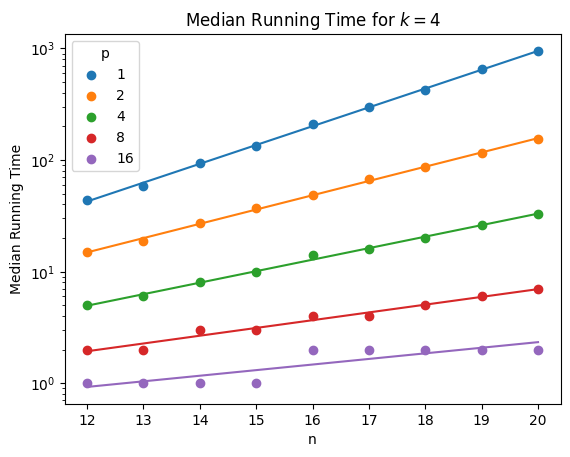

<Figure size 1500x1000 with 0 Axes>

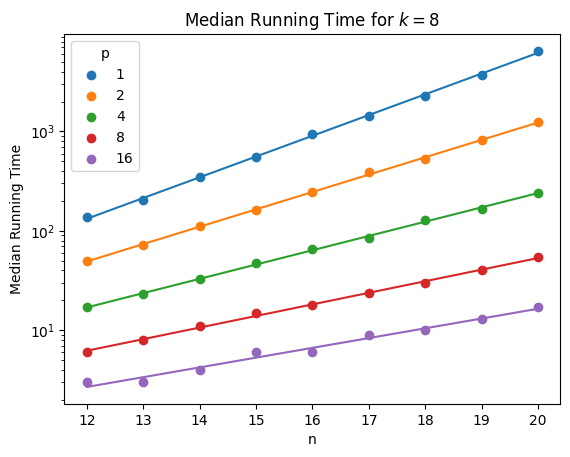

In [169]:
# Plot mrt p=1,2,4,8,16
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]

	for (p, mrt) in zip(ps, mrtk):

		# Point
		ax.scatter(ns, mrt, label=p)

		# Line of best fit
		coefficients, error = np.polyfit(ns, np.log(mrt), 1, cov=True)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)))

	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

We evaluate the relationship

$$p_{succ} = \frac{1}{mrt}$$

<Figure size 1500x1000 with 0 Axes>

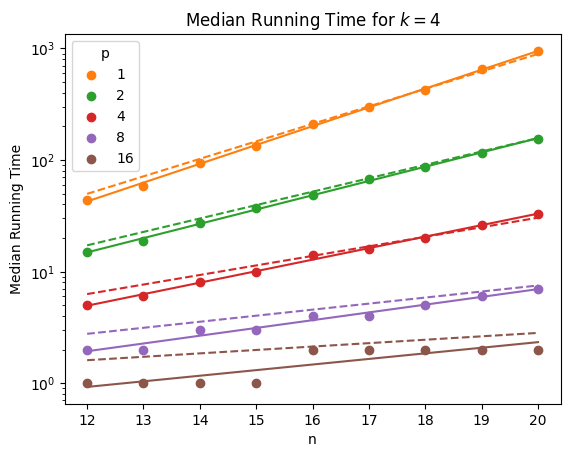

<Figure size 1500x1000 with 0 Axes>

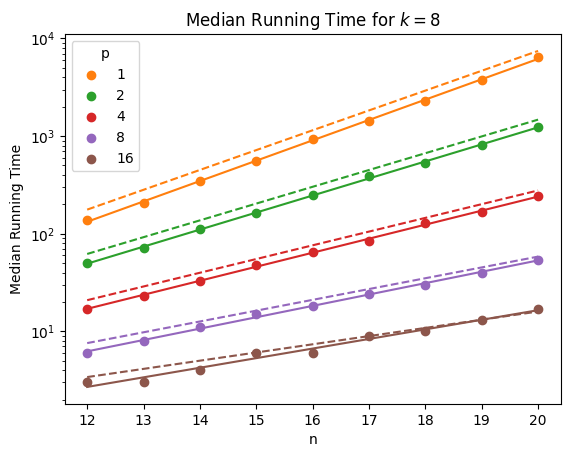

In [170]:
# Plot psucc vs mrt p=1,2,4,8,16
colourmap = plt.cm.get_cmap('tab10')
colours = [colourmap(i+1) for i in range(len(ps))]
for k in ks:
	plt.figure(figsize=(15, 10))
	fig, ax = plt.subplots()
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]

	for (p, mrt, colour, psucc) in zip(ps, mrtk, colours, psucck):

		# mrt
		ax.scatter(ns, mrt, label=p, color=colour)
		coefficients = np.polyfit(ns, np.log(mrt), 1)
		polynomial = np.poly1d(coefficients)
		ax.plot(ns, np.exp(polynomial(ns)), color=colour)

		#psucc
		coefficients = np.polyfit(ns, np.log(psucc), 1)
		polynomial = np.poly1d(-1 * coefficients)
		ax.plot(ns, np.exp(polynomial(ns)), color=colour, linestyle='dashed')


	ax.set_yscale('log')
	ax.set_xlabel('n')
	ax.set_ylabel('Median Running Time')
	ax.legend(title='p')
	ax.set_title('Median Running Time'+ f' for $k = {k}$')

Coefficients:

In [171]:
# Calculate coeffs p=1,2,4,8,16
psucc_coeffs = {k : {p : {} for p in ps} for k in ks}
mrt_coeffs = {k : {p : {} for p in ps} for k in ks}

for k in ks:
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	psucck = [[psuccs[k][n][p] for n in ns] for p in ps]
	for (p, mrtk, psucc) in zip(ps, mrtk, psucck):
		# mrt
		coefficients = np.polyfit(ns, np.log(mrtk), 1)
		mrt_coeffs[k][p]['c'] = list(coefficients)
		#psucc
		coefficients = np.polyfit(ns, np.log(psucc), 1)
		psucc_coeffs[k][p]['c'] = list(coefficients)

Next, we benchmark against WalkSAT

In [172]:
# Extract mrt WalkSAT
dir = f'{parent_dir}/experiments/ksat_benchmark/walksat_eval'
ws_rts = {k : {n : torch.zeros(size=(num_proc * batch_size, )) for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for proc in range(num_proc):
			filename = f'{dir}/rt_{n}_{k}_{proc * batch_size}.hdf5' 
			with h5py.File(filename, 'r') as file:
				fresh = torch.from_numpy(file.get('times')[:])
				index = proc * batch_size
				ws_rts[k][n][index : index + batch_size] = fresh

ws_mrts = {k : {n : torch.median(ws_rts[k][n]) for n in ns} for k in ks}

In addition, we extract the median running times for larger values of $p$ in QAOA to confirm the asymptotic limit

In [173]:
# Extract mrt p=20, 24, 28, 32
ps = [20, 24, 28, 32]
ns = [i for i in range(12, 20)]
num_proc = 50
batch_size = 50
dir = f'{parent_dir}/experiments/ksat_benchmark/p_20-32'
rts = {k : {n : {p : torch.zeros(size=(num_proc * batch_size, )) for p in ps} for n in ns} for k in ks}
for k in ks:
	for n in ns:
		for p in ps:
			for proc in range(num_proc):
				filename = f'{dir}/rt_{n}_{k}_{p}_{proc * batch_size}.hdf5' 
				with h5py.File(filename, 'r') as file:
					fresh = torch.from_numpy(file.get('times')[:])
					index = proc * batch_size
					rts[k][n][p][index : index + batch_size] = fresh
			mrts[k][n][p] = torch.median(rts[k][n][p])

<Figure size 1500x1000 with 0 Axes>

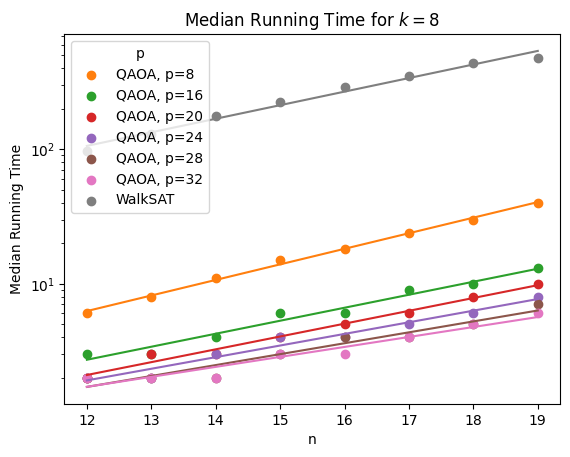

In [181]:
# Plot mrt k=8 WalkSAT vs. p=8, 16, 20, 24, 28, 32
k=8
plt.figure(figsize=(15, 10))
fig, ax = plt.subplots()

# QAOA
ps = [8,16,20,24,28,32]
colourmap = plt.cm.get_cmap('tab10')
colours = [colourmap(i+1) for i in range(10)]
mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
for (p, mrt, colour) in zip(ps, mrtk, colours):
	ax.scatter(ns, mrt, label=f'QAOA, p={p}', color=colour)
	coefficients = np.polyfit(ns, np.log(mrt), 1)
	polynomial = np.poly1d(coefficients)
	ax.plot(ns, np.exp(polynomial(ns)), color=colour)

# WalkSAT
colour = colours[len(ps)]
ws_mrtk = [ws_mrts[k][n] for n in ns]
ax.scatter(ns, ws_mrtk, label='WalkSAT', color=colour)
coefficients = np.polyfit(ns, np.log(ws_mrtk), 1)
polynomial = np.poly1d(coefficients)
ax.plot(ns, np.exp(polynomial(ns)), color=colour)

ax.set_yscale('log')
ax.set_xlabel('n')
ax.set_ylabel('Median Running Time')
ax.legend(title='p')
ax.set_title('Median Running Time'+ f' for $k = {k}$')
plt.show()

Coefficients

In [175]:
# Calculate coeffs p=20,24,28,32 and WalkSAT
ps=[20,24,28,32]
for k in ks:
	# WalkSAT
	mrt_coeffs[k]['WS'] = {}
	ws_mrtk = [ws_mrts[k][n] for n in ns]
	coefficients, error = np.polyfit(ns, np.log(ws_mrtk), 1, cov=True)
	mrt_coeffs[k]['WS']['c'] = list(coefficients)
	mrt_coeffs[k]['WS']['r'] = list(error)

	# QAOA
	mrtk = [[mrts[k][n][p] for n in ns] for p in ps]
	for (p, mrtk) in zip(ps, mrtk):
		mrt_coeffs[k][p] = {}
		# mrt
		coefficients, error = np.polyfit(ns, np.log(mrtk), 1, cov=True)
		mrt_coeffs[k][p]['c'] = list(coefficients)
		mrt_coeffs[k][p]['r'] = list(error)


In [176]:
ps = [1,2,4,8,16,20,24,28,32]
for p in ps:
    print(f"Running time coefficient (k = 8) for p = {p}: {mrt_coeffs[8][p]['c'][0]}")
print(f"Running time coefficient (k = 8) for WalkSAT: {mrt_coeffs[8]['WS']['c'][0]}")

Running time coefficient (k = 8) for p = 1: 0.4801237106323247
Running time coefficient (k = 8) for p = 2: 0.4019540786743167
Running time coefficient (k = 8) for p = 4: 0.33088153998057074
Running time coefficient (k = 8) for p = 8: 0.26823033491770437
Running time coefficient (k = 8) for p = 16: 0.22625769376754773
Running time coefficient (k = 8) for p = 20: 0.2199142490114485
Running time coefficient (k = 8) for p = 24: 0.19916189284551708
Running time coefficient (k = 8) for p = 28: 0.18711807898112703
Running time coefficient (k = 8) for p = 32: 0.17084739889417377
Running time coefficient (k = 8) for WalkSAT: 0.23248631045931853
